### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [1]:
#import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from scipy import stats

import xgboost as xgb


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

c:\Users\mario.segura\Anaconda3\envs\Nuclio\Lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# ! pip install xgboost==1.3.3

In [4]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.24.3
Pandas version 1.5.1
XGBoost version 1.3.3


In [5]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

# DATA_PATH = ""

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [6]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
11263,2013-04-30,53_7894,18,53,6,7894,1490.0,1.0
12107,2015-02-28,56_7894,1,56,6,7894,2190.0,4.0
1977,2014-06-30,21_5822,7,21,35,5822,1049.0,18.0
5437,2015-05-31,28_12134,7,28,30,12134,399.0,2.0
4850,2013-08-31,28_7220,7,28,22,7220,1299.0,5.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [8]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido. 

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u> 

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por **"notebook funcional"** entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Tratar los nulos.
1. Realizar un pequeño EDA sobre el dataset.
1. Crear algunas variables rápidas para el entrenamiento.
1. Entrenar el algoritmo.
1. Evaluar el modelo.
1. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 426 Series Temporales en el dataset:

In [9]:
df["unique_id"].nunique()

426

Veamos cuales son las fechas min y max de nuestro dataset:

In [10]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [11]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [12]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [13]:
sample_ts = "31_4249"

In [14]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [15]:
df["monthly_sales"].fillna(0, inplace = True)

In [16]:
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.backfill().ffill()
)

In [17]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [18]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [19]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [20]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [21]:
y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre

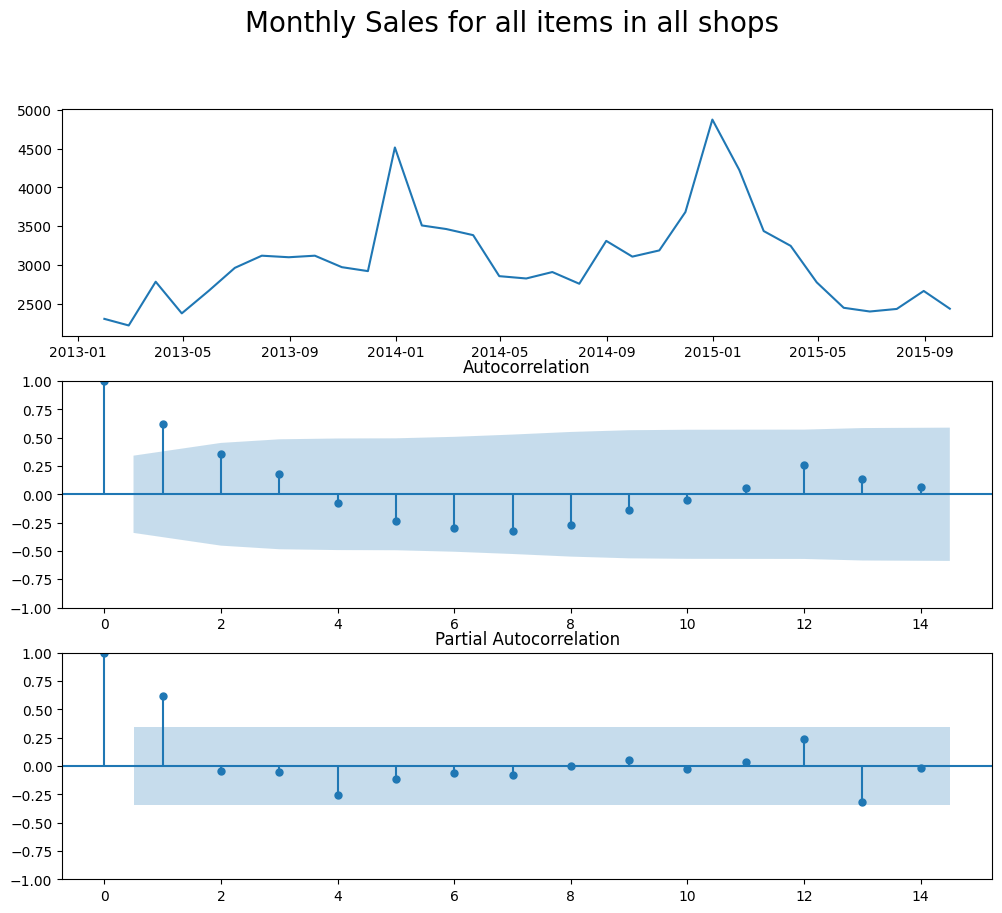

In [22]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: más de 400 Series Temporales diferentes tendríamos que entrenar 400 ARIMAs (1 modelo por Serie Temporal). En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 400 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

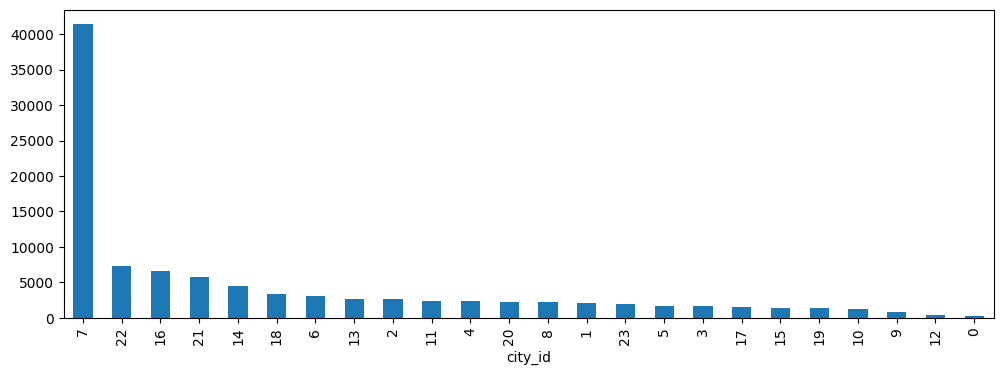

In [23]:
(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

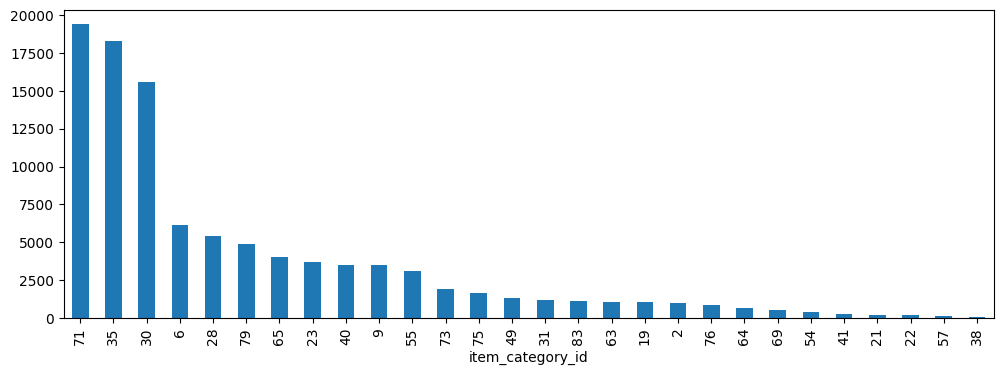

In [24]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### Preguntas formulario 

El id de la categoría con los mayores ingresos en el mes de Septiembre-2015 es:  
  
35

In [25]:
df['revenue'] = df['monthly_average_price'] * df['monthly_sales']

In [26]:
(
    df[(df['date'] > '2015-08-31') & (df['date'] < '2015-10-01')]
    .groupby(['date', 'item_category_id'])
    ['revenue'].max()
    .sort_values(ascending=False)
)

date        item_category_id
2015-09-30  35                  50382.000000
            9                   39641.028139
            79                  37091.772575
            75                  27920.000000
            73                  26106.666667
            6                   18479.708333
            76                  16800.000000
            28                  13487.400000
            2                   12360.000000
            31                  11458.000000
            23                  10791.000000
            41                   9995.000000
            63                   9441.000000
            19                   5993.000000
            69                   5593.000000
            64                   5593.000000
            22                   3897.000000
            40                   3843.000000
            65                   3493.000000
            30                   3493.000000
            49                   3485.142857
            55            

In [27]:
(
    df[(df['date'] > '2015-08-31') & (df['date'] < '2015-10-01')]
    .groupby(['date', 'item_category_id'])
    ['monthly_sales'].max()
    .sort_values(ascending=False)
)

date        item_category_id
2015-09-30  9                   30.0
            79                  30.0
            76                  30.0
            71                  30.0
            35                  29.0
            28                  18.0
            31                  17.0
            83                  16.0
            30                  14.0
            63                  12.0
            49                  12.0
            23                   9.0
            73                   8.0
            65                   8.0
            75                   8.0
            64                   7.0
            6                    7.0
            40                   7.0
            69                   7.0
            54                   6.0
            19                   6.0
            41                   5.0
            55                   5.0
            2                    4.0
            22                   3.0
            21                   3.0
         

El id de la categoría que tiene mayor número de item_id diferentes es:
  
40 con 24

In [28]:
(
    df.
    groupby(['item_category_id'])
    ['item_id'].nunique()
    .sort_values(ascending = False)
)

item_category_id
40    24
55    19
30    12
49     9
65     8
63     7
31     6
75     5
23     5
9      4
73     4
35     4
19     3
64     3
6      3
83     2
54     2
28     2
57     1
41     1
38     1
69     1
71     1
22     1
21     1
76     1
79     1
2      1
Name: item_id, dtype: int64

In [29]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500


El mes con el mayor número de ventas ha sido (todos los artículos)  
  
2014-12-31    4874.0

In [30]:
(
    df.
    groupby(['date'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
)

date
2014-12-31    4874.0
2013-12-31    4514.0
2015-01-31    4223.0
2014-11-30    3681.0
2014-01-31    3508.0
2014-02-28    3462.0
2015-02-28    3436.0
2014-03-31    3383.0
2014-08-31    3309.0
2015-03-31    3245.0
2014-10-31    3186.0
2013-07-31    3118.0
2013-09-30    3118.0
2014-09-30    3106.0
2013-08-31    3098.0
2013-10-31    2970.0
2013-06-30    2961.0
2013-11-30    2919.0
2014-06-30    2907.0
2014-04-30    2854.0
2014-05-31    2824.0
2013-03-31    2782.0
2015-04-30    2774.0
2014-07-31    2756.0
2013-05-31    2665.0
2015-08-31    2663.0
2015-05-31    2446.0
2015-09-30    2434.0
2015-07-31    2431.0
2015-06-30    2398.0
2013-04-30    2374.0
2013-01-31    2303.0
2013-02-28    2218.0
2015-10-31       0.0
Name: monthly_sales, dtype: float64

In [31]:
(
    df.
    groupby(['date'])
    ['monthly_sales'].sum()
    
)

date
2013-01-31    2303.0
2013-02-28    2218.0
2013-03-31    2782.0
2013-04-30    2374.0
2013-05-31    2665.0
2013-06-30    2961.0
2013-07-31    3118.0
2013-08-31    3098.0
2013-09-30    3118.0
2013-10-31    2970.0
2013-11-30    2919.0
2013-12-31    4514.0
2014-01-31    3508.0
2014-02-28    3462.0
2014-03-31    3383.0
2014-04-30    2854.0
2014-05-31    2824.0
2014-06-30    2907.0
2014-07-31    2756.0
2014-08-31    3309.0
2014-09-30    3106.0
2014-10-31    3186.0
2014-11-30    3681.0
2014-12-31    4874.0
2015-01-31    4223.0
2015-02-28    3436.0
2015-03-31    3245.0
2015-04-30    2774.0
2015-05-31    2446.0
2015-06-30    2398.0
2015-07-31    2431.0
2015-08-31    2663.0
2015-09-30    2434.0
2015-10-31       0.0
Name: monthly_sales, dtype: float64

df.columns()

In [32]:
df.columns

Index(['date', 'unique_id', 'city_id', 'shop_id', 'item_category_id',
       'item_id', 'monthly_average_price', 'monthly_sales', 'revenue'],
      dtype='object')

In [33]:
df['rolling_sales'] = df['monthly_sales'].rolling(window=3).sum()

# Puedes seleccionar solo las columnas relevantes si es necesario

In [34]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,rolling_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,87.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,84.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,87.0


In [35]:
(
    df.
    groupby(['date'])
    ['monthly_sales'].sum()
    .rolling(window=1).mean()
)

date
2013-01-31    2303.0
2013-02-28    2218.0
2013-03-31    2782.0
2013-04-30    2374.0
2013-05-31    2665.0
2013-06-30    2961.0
2013-07-31    3118.0
2013-08-31    3098.0
2013-09-30    3118.0
2013-10-31    2970.0
2013-11-30    2919.0
2013-12-31    4514.0
2014-01-31    3508.0
2014-02-28    3462.0
2014-03-31    3383.0
2014-04-30    2854.0
2014-05-31    2824.0
2014-06-30    2907.0
2014-07-31    2756.0
2014-08-31    3309.0
2014-09-30    3106.0
2014-10-31    3186.0
2014-11-30    3681.0
2014-12-31    4874.0
2015-01-31    4223.0
2015-02-28    3436.0
2015-03-31    3245.0
2015-04-30    2774.0
2015-05-31    2446.0
2015-06-30    2398.0
2015-07-31    2431.0
2015-08-31    2663.0
2015-09-30    2434.0
2015-10-31       0.0
Name: monthly_sales, dtype: float64

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [37]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, lags ):
    
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    # ! he cambiado esta función, ahora tenemos lags
    for lag in range(lags):    
        lag += 1
        gb_df_[f"{new_name}_lag{lag}"] = gb_df_.groupby(gb_list)[new_name].transform(
            lambda series: series.shift(lag)
        )
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_

In [38]:
'''def build_ts_vars_roll(df, gb_list, target_column, agg_func, agg_func_name, lags, rolling):
    
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .rolling(window = rolling)
        .apply(agg_func)
        .resample("M")[target_column]
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    # ! he cambiado esta función, ahora tenemos lags
    for lag in range(lags):    
        lag += 1
        gb_df_[f"{new_name}_lag{lag}"] = gb_df_.groupby(gb_list)[new_name].transform(
            lambda series: series.shift(lag)
        )
    
    

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_'''

'def build_ts_vars_roll(df, gb_list, target_column, agg_func, agg_func_name, lags, rolling):\n    \n    assert "date" in df.columns.tolist(), "Date must be in df columns"\n    \n    new_name = "_".join(gb_list + [target_column] + [agg_func_name])\n\n    gb_df_ = (\n        df\n        .set_index("date")\n        .groupby(gb_list)\n        .rolling(window = rolling)\n        .apply(agg_func)\n        .resample("M")[target_column]\n        .to_frame()\n        .reset_index()\n        .rename(\n            columns = {\n                target_column : new_name\n            }\n        )\n    )\n\n    # ! he cambiado esta función, ahora tenemos lags\n    for lag in range(lags):    \n        lag += 1\n        gb_df_[f"{new_name}_lag{lag}"] = gb_df_.groupby(gb_list)[new_name].transform(\n            lambda series: series.shift(lag)\n        )\n    \n    \n\n    print(f"Dropping columns that might cause target leakage {new_name}")\n    gb_df_.drop(new_name, inplace = True, axis = 1)\n    \n    

Según el gráfico de autocorrelación, no tiene mucho sentido hacer 2 lags

In [39]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,rolling_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,87.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,84.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,87.0


In [40]:
GB_LIST = ["item_id", "city_id", "shop_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"
LAGS = 1

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
    lags=LAGS
    
)

vars_ts_.head(10)

Dropping columns that might cause target leakage item_id_city_id_shop_id_monthly_sales_sum


,item_id,city_id,shop_id,date,item_id_city_id_shop_id_monthly_sales_sum_lag1
0,32,7,31,2013-01-31,NaN
1,32,7,31,2013-02-28,24.0
2,32,7,31,2013-03-31,20.0
3,32,7,31,2013-04-30,13.0
4,32,7,31,2013-05-31,11.0
5,32,7,31,2013-06-30,6.0
6,32,7,31,2013-07-31,11.0
7,32,7,31,2013-08-31,10.0
8,32,7,31,2013-09-30,9.0
9,32,7,31,2013-10-31,2.0


In [41]:
GB_LIST2 = ["item_id"]
TARGET_COLUMN2 = "monthly_sales"
AGG_FUNC2 = np.sum
AGG_FUNC_NAME2 = "sum"
LAGS = 1

vars_ts_2 = build_ts_vars(
    df = df,
    gb_list = GB_LIST2,
    target_column = TARGET_COLUMN2,
    agg_func = AGG_FUNC2,
    agg_func_name =  AGG_FUNC_NAME2,
    lags = 1
    
)

vars_ts_2.head(10)

Dropping columns that might cause target leakage item_id_monthly_sales_sum


,item_id,date,item_id_monthly_sales_sum_lag1
0,32,2013-01-31,NaN
1,32,2013-02-28,24.0
2,32,2013-03-31,20.0
3,32,2013-04-30,13.0
4,32,2013-05-31,11.0
5,32,2013-06-30,6.0
6,32,2013-07-31,11.0
7,32,2013-08-31,10.0
8,32,2013-09-30,9.0
9,32,2013-10-31,2.0


In [42]:
GB_LIST3 = ["item_id", "city_id", "shop_id"]
TARGET_COLUMN3 = "monthly_sales"
AGG_FUNC3 = np.sum
AGG_FUNC_NAME3 = "sum"
LAGS = 2

vars_ts_3 = build_ts_vars(
    df = df,
    gb_list = GB_LIST3,
    target_column = TARGET_COLUMN3,
    agg_func = AGG_FUNC3,
    agg_func_name =  AGG_FUNC_NAME3,
    lags = LAGS
)

vars_ts_3.head(10)

Dropping columns that might cause target leakage item_id_city_id_shop_id_monthly_sales_sum


,item_id,city_id,shop_id,date,item_id_city_id_shop_id_monthly_sales_sum_lag1,item_id_city_id_shop_id_monthly_sales_sum_lag2
0,32,7,31,2013-01-31,NaN,NaN
1,32,7,31,2013-02-28,24.0,NaN
2,32,7,31,2013-03-31,20.0,24.0
3,32,7,31,2013-04-30,13.0,20.0
4,32,7,31,2013-05-31,11.0,13.0
5,32,7,31,2013-06-30,6.0,11.0
6,32,7,31,2013-07-31,11.0,6.0
7,32,7,31,2013-08-31,10.0,11.0
8,32,7,31,2013-09-30,9.0,10.0
9,32,7,31,2013-10-31,2.0,9.0


In [43]:
GB_LIST4 = ["item_id", "city_id", "shop_id"]
TARGET_COLUMN4 = "monthly_sales"
AGG_FUNC4 = np.sum
AGG_FUNC_NAME4 = "sum"
LAGS = 1

vars_ts_4 = build_ts_vars(
    df = df,
    gb_list = GB_LIST4,
    target_column = TARGET_COLUMN4,
    agg_func = AGG_FUNC4,
    agg_func_name =  AGG_FUNC_NAME4, 
    lags=1
    
)

vars_ts_4.head(10)

Dropping columns that might cause target leakage item_id_city_id_shop_id_monthly_sales_sum


,item_id,city_id,shop_id,date,item_id_city_id_shop_id_monthly_sales_sum_lag1
0,32,7,31,2013-01-31,NaN
1,32,7,31,2013-02-28,24.0
2,32,7,31,2013-03-31,20.0
3,32,7,31,2013-04-30,13.0
4,32,7,31,2013-05-31,11.0
5,32,7,31,2013-06-30,6.0
6,32,7,31,2013-07-31,11.0
7,32,7,31,2013-08-31,10.0
8,32,7,31,2013-09-30,9.0
9,32,7,31,2013-10-31,2.0


In [44]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,rolling_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,87.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,84.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,87.0


In [45]:
df.columns

Index(['date', 'unique_id', 'city_id', 'shop_id', 'item_category_id',
       'item_id', 'monthly_average_price', 'monthly_sales', 'revenue',
       'rolling_sales'],
      dtype='object')

## Posibles ideas  
  
Desde la función build_ts_vars  
  
1. Promedio móvil mensual de ventas: Podrías calcular el promedio de las ventas en los últimos meses para cada tienda y producto. Esto puede ayudarte a identificar tendencias a largo plazo.  
  
2. Varianza mensual de ventas: Similar al promedio móvil, pero calculando la varianza de las ventas en los últimos meses. Esto puede ser útil para identificar volatilidad en las ventas.
3. Crecimiento mensual de ventas: Calcular el cambio porcentual en las ventas de un mes a otro para cada tienda y producto. Esto puede ayudarte a identificar si las ventas están aumentando o disminuyendo.
4. Número de productos vendidos: Si tienes información sobre cuántas veces se vendió cada producto en un mes, podrías crear una columna que cuente el número total de ventas de ese producto en un mes.
5. Ventas totales mensuales: Similar a la anterior, pero multiplicando el precio medio por el número total de ventas. Esto te daría las ventas totales para cada producto en un mes.
6. Índice de volatilidad de precios: Si tienes información sobre el precio de venta de cada producto cada día, podrías calcular la volatilidad de estos precios.
7. Días con ventas máximas: Si tienes información sobre las ventas diarias, podrías determinar en qué días se realizaron las ventas más altas.
8. Días con ventas mínimas: Similar a la anterior, pero identificando los días con las ventas más bajas.
9. Ventas acumulativas: Podrías calcular la cantidad total de ventas de un producto hasta la fecha actual.
10. Cambio porcentual de ventas: Similar a la crecimiento mensual de ventas, pero calculando el cambio porcentual en las ventas de un día a otro.  
  
Ideas sin la función build_ts_vars  
  
1. Extracción de características basadas en la fecha: Podrías extraer características como el día de la semana, el mes del año, etc., de la columna de fecha 2.  
  
2. Creación de características cíclicas: Podrías crear características cíclicas utilizando funciones trigonométricas (seno y coseno) para capturar patrones estacionales en los datos 4.
3. Características de ventanas deslizantes: Podrías crear características que resuman valores sobre una ventana fija de pasos de tiempo anteriores 1.
4. Creación de características de ventana expandida: Similar a las ventanas deslizantes, pero utilizando toda la historia de datos hasta la fecha actual 1.
5. Transformación de características categóricas: Si tienes columnas categóricas en tu conjunto de datos, podrías utilizar técnicas como la codificación one-hot para convertirlas en características numéricas 4.
6. Normalización de características: Podrías normalizar tus características para que todas estén en la misma escala. Esto puede mejorar el rendimiento de algunos algoritmos de aprendizaje automático.
7. Detección de outliers: Podrías detectar outliers en tus características y manejarlos adecuadamente. Por ejemplo, podrías eliminar filas con outliers extremos o reemplazarlos con la mediana de los valores.
8. Creación de interacciones entre características: Podrías crear nuevas características que representen las interacciones entre diferentes características. Por ejemplo, podrías crear una nueva característica que sea el producto de dos características existentes.
9. Creación de polinomios de características: Podrías crear polinomios de características para capturar relaciones no lineales entre tus características y la variable objetivo.
10. Creación de características de frecuencia: Podrías crear características que representen la frecuencia de eventos específicos en tus datos. Por ejemplo, podrías crear una característica que represente el número de días consecutivos con ventas por debajo de un umbral determinado.

<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [46]:
print(df.shape)

df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")

print(df.shape)

(14484, 10)
(14484, 11)


In [47]:
print(df.shape)

df = pd.merge(df, vars_ts_2, on = ["date"] + GB_LIST2, how = "left")

print(df.shape)

(14484, 11)
(14484, 12)


In [48]:
print(df.shape)

df = pd.merge(df, vars_ts_3, on = ["date"] + GB_LIST3, how = "left")

print(df.shape)

(14484, 12)
(14484, 14)


In [49]:
print(df.shape)

df = pd.merge(df, vars_ts_4, on = ["date"] + GB_LIST4, how = "left")

print(df.shape)

(14484, 14)
(14484, 15)


In [52]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,rolling_sales,item_id_city_id_shop_id_monthly_sales_sum_lag1_x,item_id_monthly_sales_sum_lag1,item_id_city_id_shop_id_monthly_sales_sum_lag2,item_id_city_id_shop_id_monthly_sales_sum_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,NaN,30.0,30.0,NaN,30.0
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,87.0,27.0,27.0,30.0,27.0
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,84.0,30.0,30.0,27.0,30.0
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,87.0,27.0,27.0,30.0,27.0


In [51]:
del df['item_id_city_id_shop_id_monthly_sales_sum_lag1_y']

In [69]:
del df['revenue']

In [85]:
del df['rolling_sales']

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [86]:
df.columns.tolist()

['date',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'item_id_city_id_shop_id_monthly_sales_sum_lag1_x',
 'item_id_monthly_sales_sum_lag1',
 'item_id_city_id_shop_id_monthly_sales_sum_lag2',
 'item_id_city_id_shop_id_monthly_sales_sum_lag1']

In [87]:
COLUMNS_TO_DROP = [
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [88]:
df.set_index("unique_id", inplace = True)

KeyError: "None of ['unique_id'] are in the columns"

In [89]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,item_id_city_id_shop_id_monthly_sales_sum_lag1_x,item_id_monthly_sales_sum_lag1,item_id_city_id_shop_id_monthly_sales_sum_lag2,item_id_city_id_shop_id_monthly_sales_sum_lag1
unique_id,,,,,,,,,,,
21_5823,2013-07-31,7,21,35,5823,2598.958333,0.0,3.0,59.0,0.0,3.0
3_5822,2014-07-31,0,3,35,5822,1049.000000,4.0,4.0,377.0,5.0,4.0
31_11655,2015-08-31,7,31,41,11655,1999.000000,4.0,4.0,10.0,3.0,4.0
25_4249,2013-05-31,7,25,23,4249,1599.000000,4.0,9.0,28.0,6.0,9.0
46_16227,2015-07-31,11,46,65,16227,499.000000,7.0,3.0,33.0,2.0,3.0


In [90]:
train_index = sorted(list(df["date"].unique()))[:-2] #todos los meses menos 2 para train 

valida_index = [sorted(list(df["date"].unique()))[-2]] 

test_index = [sorted(list(df["date"].unique()))[-1]] #un mes de test

In [91]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [numpy.datetime64('2013-01-31T00:00:00.000000000'), numpy.datetime64('2013-02-28T00:00:00.000000000')] - ... - [numpy.datetime64('2015-07-31T00:00:00.000000000'), numpy.datetime64('2015-08-31T00:00:00.000000000')]

Our validation index is [numpy.datetime64('2015-09-30T00:00:00.000000000')]

Our test/prediction index is [numpy.datetime64('2015-10-31T00:00:00.000000000')]



In [92]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

In [93]:
X_train.head()

,city_id,shop_id,item_category_id,item_id,monthly_average_price,item_id_city_id_shop_id_monthly_sales_sum_lag1_x,item_id_monthly_sales_sum_lag1,item_id_city_id_shop_id_monthly_sales_sum_lag2,item_id_city_id_shop_id_monthly_sales_sum_lag1
unique_id,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,30.0,30.0,NaN,30.0
12_11365,16,12,9,11365,3252.470238,27.0,27.0,30.0,27.0
12_11365,16,12,9,11365,1590.515152,30.0,30.0,27.0,30.0
12_11365,16,12,9,11365,1447.531250,27.0,27.0,30.0,27.0


<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [94]:
#model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175 )
model = xgb.XGBRegressor(n_estimators = 500, max_depth = 4, eta=0.1)

model.fit(
    X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds =45 #intenta medir el sobreajuste, si durante 15 rondas de entrenamiento solo baja un punto deja el anterior
    )

[0]	validation_0-rmse:9.54707	validation_1-rmse:8.23310
[1]	validation_0-rmse:8.80909	validation_1-rmse:7.52568
[2]	validation_0-rmse:8.16021	validation_1-rmse:6.89834
[3]	validation_0-rmse:7.59194	validation_1-rmse:6.35311
[4]	validation_0-rmse:7.09454	validation_1-rmse:5.86209
[5]	validation_0-rmse:6.66364	validation_1-rmse:5.44463
[6]	validation_0-rmse:6.29141	validation_1-rmse:5.08092
[7]	validation_0-rmse:5.97132	validation_1-rmse:4.75961
[8]	validation_0-rmse:5.69453	validation_1-rmse:4.48989
[9]	validation_0-rmse:5.45841	validation_1-rmse:4.26202
[10]	validation_0-rmse:5.25824	validation_1-rmse:4.06448
[11]	validation_0-rmse:5.08753	validation_1-rmse:3.89947
[12]	validation_0-rmse:4.94399	validation_1-rmse:3.76109
[13]	validation_0-rmse:4.82316	validation_1-rmse:3.64469
[14]	validation_0-rmse:4.72248	validation_1-rmse:3.54952
[15]	validation_0-rmse:4.63579	validation_1-rmse:3.47451
[16]	validation_0-rmse:4.56276	validation_1-rmse:3.42564
[17]	validation_0-rmse:4.50075	validation

[32]	validation_0-rmse:4.14956	validation_1-rmse:3.18502
[33]	validation_0-rmse:4.14009	validation_1-rmse:3.18202
[34]	validation_0-rmse:4.13330	validation_1-rmse:3.18404
[35]	validation_0-rmse:4.12505	validation_1-rmse:3.18601
[36]	validation_0-rmse:4.11721	validation_1-rmse:3.18686
[37]	validation_0-rmse:4.11153	validation_1-rmse:3.18013
[38]	validation_0-rmse:4.10334	validation_1-rmse:3.18015
[39]	validation_0-rmse:4.09793	validation_1-rmse:3.17296
[40]	validation_0-rmse:4.09236	validation_1-rmse:3.17222
[41]	validation_0-rmse:4.08198	validation_1-rmse:3.17696
[42]	validation_0-rmse:4.07763	validation_1-rmse:3.17696
[43]	validation_0-rmse:4.06382	validation_1-rmse:3.17583
[44]	validation_0-rmse:4.05931	validation_1-rmse:3.17461
[45]	validation_0-rmse:4.05176	validation_1-rmse:3.17104
[46]	validation_0-rmse:4.04856	validation_1-rmse:3.17419
[47]	validation_0-rmse:4.04444	validation_1-rmse:3.17548
[48]	validation_0-rmse:4.04218	validation_1-rmse:3.17633
[49]	validation_0-rmse:4.03895	

c:\Users\mario.segura\Anaconda3\envs\Nuclio\Lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[60]	validation_0-rmse:3.96932	validation_1-rmse:3.16480
[61]	validation_0-rmse:3.96705	validation_1-rmse:3.16532
[62]	validation_0-rmse:3.96350	validation_1-rmse:3.16292
[63]	validation_0-rmse:3.96098	validation_1-rmse:3.16274
[64]	validation_0-rmse:3.94822	validation_1-rmse:3.16214
[65]	validation_0-rmse:3.94452	validation_1-rmse:3.15994
[66]	validation_0-rmse:3.94191	validation_1-rmse:3.16008
[67]	validation_0-rmse:3.93860	validation_1-rmse:3.15781
[68]	validation_0-rmse:3.93595	validation_1-rmse:3.15849
[69]	validation_0-rmse:3.93410	validation_1-rmse:3.15849
[70]	validation_0-rmse:3.92582	validation_1-rmse:3.15679
[71]	validation_0-rmse:3.92416	validation_1-rmse:3.15574
[72]	validation_0-rmse:3.92238	validation_1-rmse:3.15552
[73]	validation_0-rmse:3.92018	validation_1-rmse:3.15626
[74]	validation_0-rmse:3.91691	validation_1-rmse:3.15551
[75]	validation_0-rmse:3.90742	validation_1-rmse:3.15562
[76]	validation_0-rmse:3.90039	validation_1-rmse:3.15330
[77]	validation_0-rmse:3.89541	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=20, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

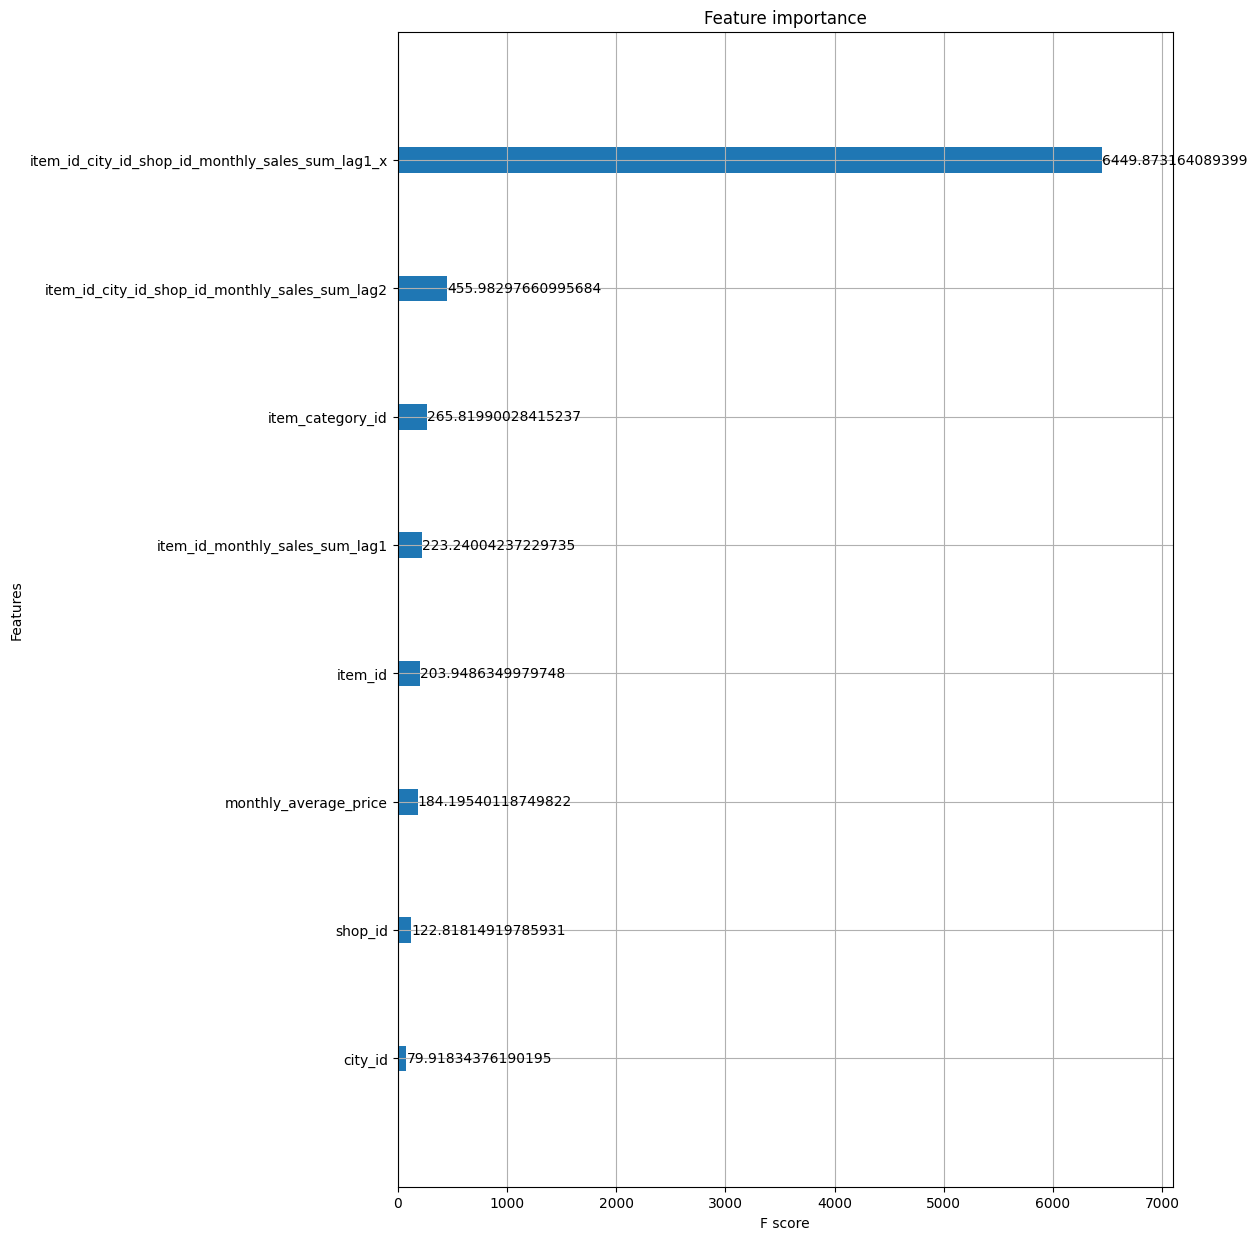

In [95]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [96]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
# Verifica que Y_test_predict sea de tipo numérico
print(Y_test_predict.dtype)
X_test["monthly_sales"] = Y_test_predict

float32


In [97]:
X_test.reset_index(inplace = True)

In [98]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

c:\Users\mario.segura\Anaconda3\envs\Nuclio\Lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [99]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 3_639
Validation RMSE: 3_064


In [100]:
(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"./submits/submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

### EL RMSE TIENE QE TENDER A 0, 
### EL MÁXIMO SERÍA 1,5 

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)